# Multitaper and Hamonic Ftest


,Time:512Hz,Epoch,FP1,FP2,F7,Fz,F8,T3,C3,Cz,C4,T4,T5,Pz,T6,O1,O2,Event Id,Event Date,Event Duration
245760,0.000000,7680,25608.505859,14121.039062,68576.742188,48837.992188,45819.820312,37762.820312,41507.660156,46537.664062,39221.453125,35901.378906,29393.214844,64635.421875,48973.937500,48114.722656,50673.058594,NaN,NaN,NaN
245761,0.001953,7680,25441.099609,13999.987305,68355.539062,48776.449219,45599.066406,37571.554688,41326.753906,46363.230469,39026.183594,35669.542969,29204.753906,64456.699219,48791.546875,47941.332031,50508.957031,NaN,NaN,NaN
245762,0.003906,7680,25322.503906,13919.011719,68160.054688,48601.175781,45407.457031,37394.296875,41123.996094,46162.609375,38818.773438,35451.226562,29003.253906,64249.867188,48586.125000,47741.089844,50307.109375,NaN,NaN,NaN
245763,0.005859,7680,25078.017578,13688.329102,67884.250000,48341.890625,45106.070312,37124.265625,40847.414062,45896.085938,38557.425781,35235.738281,28734.818359,63982.332031,48306.898438,47461.664062,50016.339844,NaN,NaN,NaN
245764,0.007812,7680,25038.996094,13635.750000,67855.023438,48237.828125,45075.062500,37076.812500,40807.519531,45856.433594,38535.421875,35230.757812,28706.617188,63945.406250,48272.617188,47415.667969,49959.218750,NaN,NaN,NaN


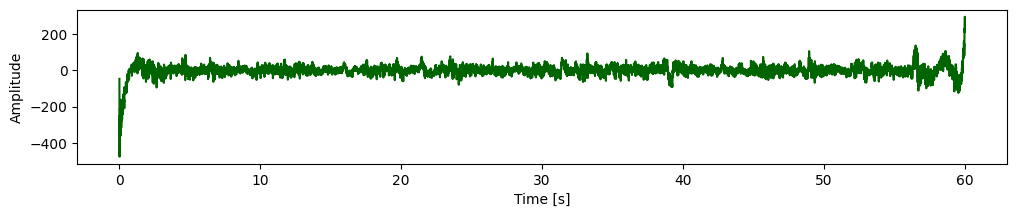

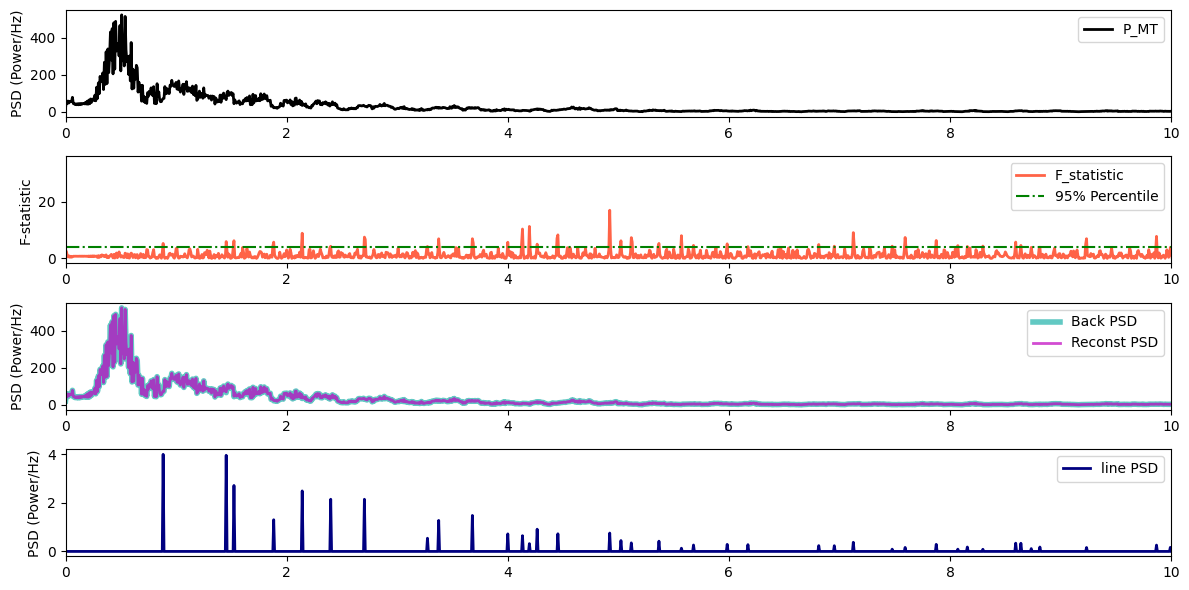

In [189]:
import numpy as np
import pandas as pd
from scipy import signal
from multitaper import MultiTaper_Periodogram
import matplotlib.pyplot as plt


df = pd.read_csv("../../test_data/record.csv")
df = df[(df["Time:512Hz"] >= 480) & (df["Time:512Hz"] <= 540)]
df["Time:512Hz"] = df["Time:512Hz"] - df["Time:512Hz"].iloc[0]
display(df.head())
fs_EEG =512
signal_EEG = df["C3"].to_numpy()
time_EEG = df["Time:512Hz"].to_numpy()


def lowpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="low")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す
def highpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="high")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す
def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "band")           #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y    

# ハイパスフィルターの設定
cutoff = 0.4  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 30    # 阻止域最小減衰[dB]
signal_EEG = highpass(signal_EEG, fs_EEG, cutoff, gpass, gstop)


cutoff = 60  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_EEG = lowpass(signal_EEG, fs_EEG, cutoff, gpass, gstop)

notch_freq = 50
Q = 30
b, a = signal.iirnotch(notch_freq, Q, fs_EEG)
signal_EEG = signal.filtfilt(b, a, signal_EEG)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(time_EEG, signal_EEG, color='darkgreen')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
plt.show()

MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(signal_EEG, fs_EEG)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(4, 1, figsize=(12, 6))  # 3行1列のサブプロット

a = 0.95  # 透明度

# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='P_MT', alpha=1, c='k', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,10)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()

# ---- 2つ目のプロット (F-statistic) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=2)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlim(0,10)
ax.legend()

# ---- 3つ目のプロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='Back PSD', alpha=0.7, c='lightseagreen', lw=4)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.7, c='m', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,10)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- 4つ目のプロット (Reconstructed PSD) ----
ax = axes[3]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='navy', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,10)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()


,Time,PPG,ECG,resp
0,0.000,1.360704,0.455078,1.750153
1,0.008,1.394917,0.404785,1.750153
2,0.016,1.444770,0.339844,1.750153
3,0.024,1.508309,0.300293,1.750153
4,0.032,1.581623,0.285156,1.624924


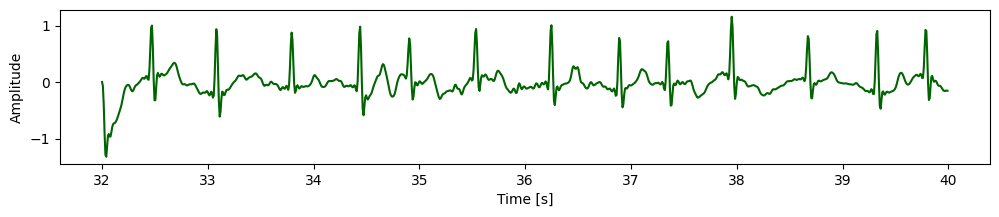

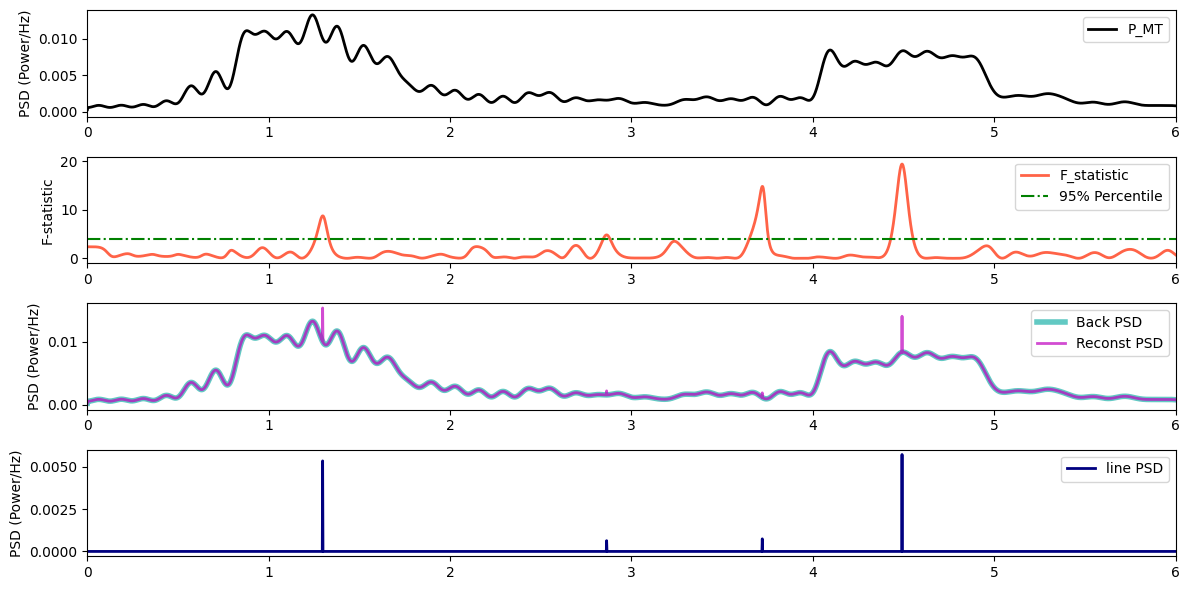

In [179]:
df_ecg = pd.read_csv("../../test_data/ECG_data.csv")

display(df_ecg.head())
fs_ECG = 125
signal_ecg = df_ecg["ECG"].iloc[4000:5000].to_numpy()
time_ecg = df_ecg["Time"].iloc[4000:5000].to_numpy()



def highpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="high")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す

# ハイパスフィルターの設定
cutoff = 1.0  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_ecg = highpass(signal_ecg, fs_ECG, cutoff, gpass, gstop)

cutoff = 25  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_ecg = lowpass(signal_ecg, fs_ECG, cutoff, gpass, gstop)

fig = plt.figure(1, figsize=(12,2))
ax = fig.add_subplot()
ax.plot(time_ecg, signal_ecg, color='darkgreen')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
plt.show()




MTSpec = MultiTaper_Periodogram(NW=4, nfft=2**16)
MTSpec.MT_Spec(signal_ecg, fs_ECG)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(4, 1, figsize=(12, 6))  # 3行1列のサブプロット

a = 0.95  # 透明度

# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='P_MT', alpha=1, c='k', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,6)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()

# ---- 2つ目のプロット (F-statistic) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=2)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlim(0,6)
ax.legend()

# ---- 3つ目のプロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='Back PSD', alpha=0.7, c='lightseagreen', lw=4)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.7, c='m', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,6)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- 4つ目のプロット (Reconstructed PSD) ----
ax = axes[3]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='navy', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,6)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()

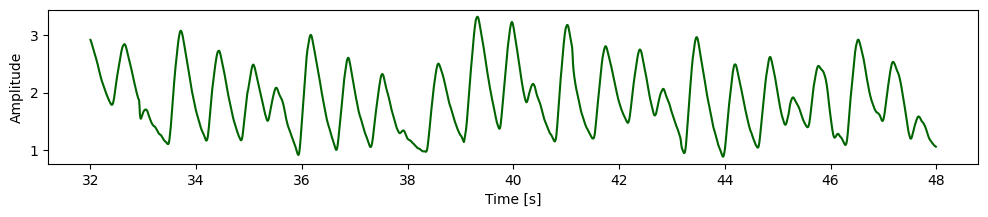

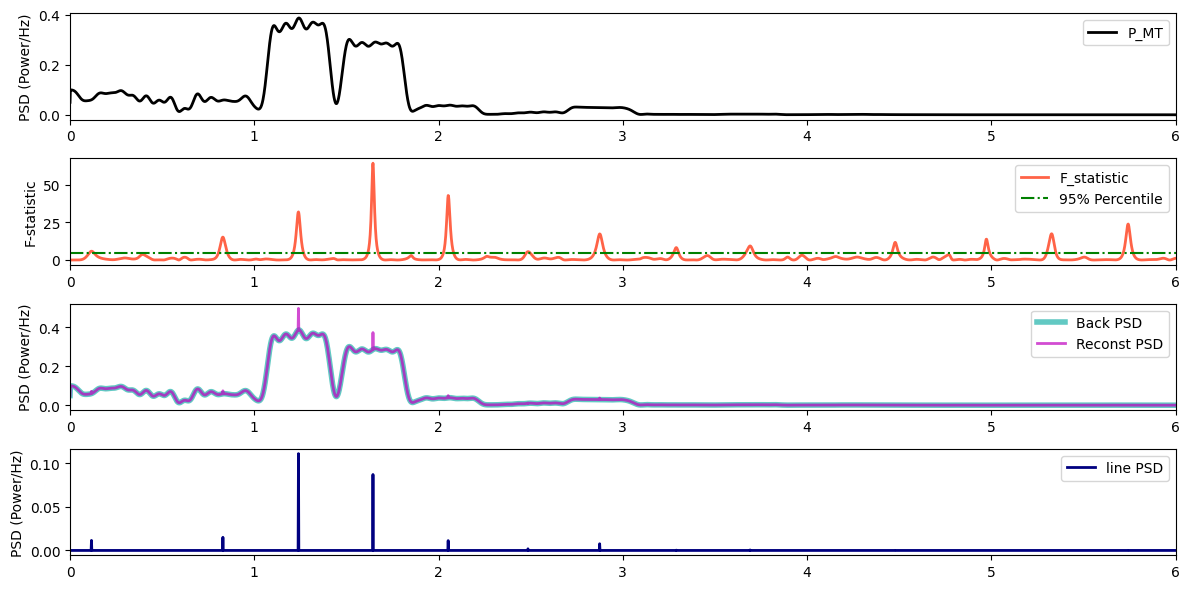

In [180]:
signal_ppg = df_ecg["PPG"].iloc[4000:6000].to_numpy()
time_ppg = df_ecg["Time"].iloc[4000:6000].to_numpy()

# signal_ppg = highpass(signal_ppg, fs_ECG, cutoff, gpass, gstop)
# signal_ppg = lowpass(signal_ppg, fs_ECG, cutoff, gpass, gstop)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(time_ppg, signal_ppg, color='darkgreen')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
plt.show()

MTSpec = MultiTaper_Periodogram(NW=3,nfft=2**16)
MTSpec.MT_Spec(signal_ppg, fs_ECG)
MTSpec.Harmonic_Ftest(p_level=0.05)


fig, axes = plt.subplots(4, 1, figsize=(12, 6))  # 3行1列のサブプロット

a = 0.95  # 透明度

# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='P_MT', alpha=1, c='k', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,6)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()

# ---- 2つ目のプロット (F-statistic) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=2)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlim(0,6)
ax.legend()

# ---- 3つ目のプロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='Back PSD', alpha=0.7, c='lightseagreen', lw=4)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.7, c='m', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,6)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- 4つ目のプロット (Reconstructed PSD) ----
ax = axes[3]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='navy', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,6)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()

## 減衰信号

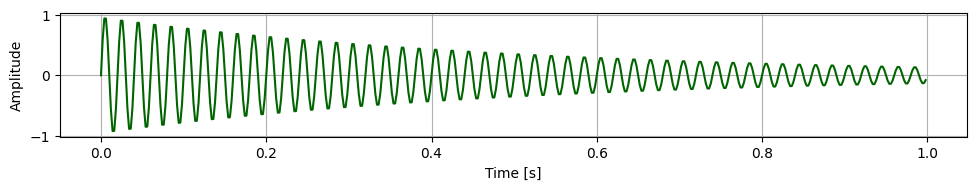

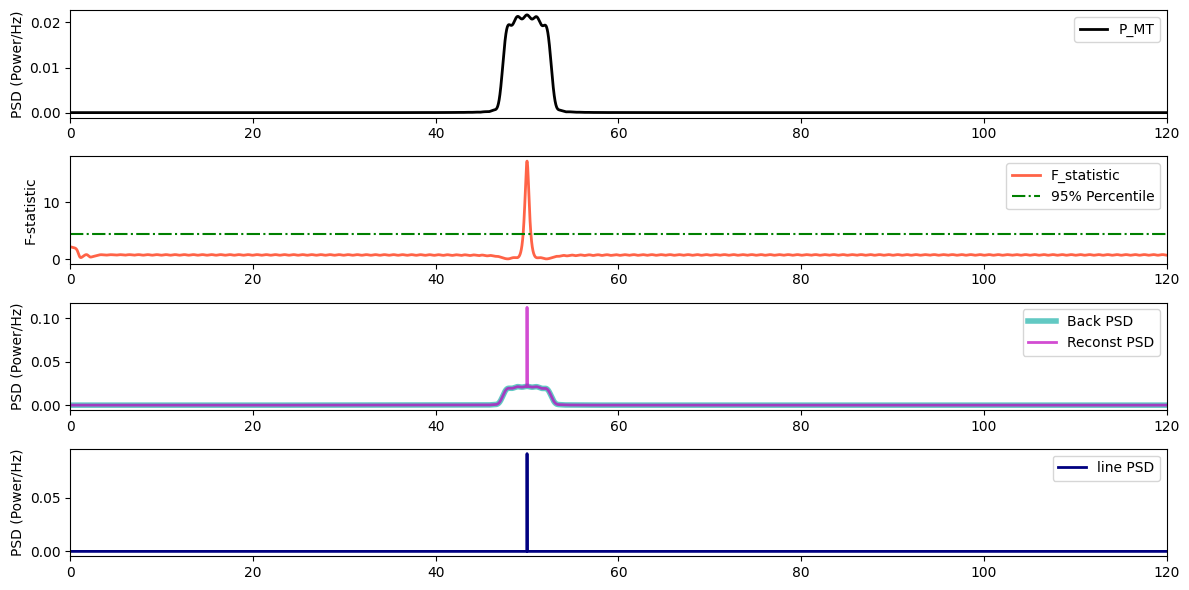

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import math


# パラメータ設定
fs_e = 500  # サンプリング周波数 (Hz)
t = np.linspace(0, 1, fs_e, endpoint=False)  # 時間軸（1秒間分のデータ）

f = 50  # 振動の周波数 (Hz)
decay_rate = 2  # 減衰率（大きいほど早く減衰）

# 減衰振動の生成
amplitude = np.exp(-decay_rate * t)  # 減衰を表す指数関数
oscillation = np.sin(2 * np.pi * f * t)  # 正弦波
# oscillation = np.clip(oscillation, -0.6, 0.6)
am_signal = amplitude * oscillation  # 減衰振動

# noisy_am_signal = am_signal
# プロット
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot()
ax.plot(t, am_signal, label="AM Signal", color='darkgreen')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.tight_layout()
plt.show()


MTSpec = MultiTaper_Periodogram(NW=3,nfft=2**16)
MTSpec.MT_Spec(am_signal, fs_e)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(4, 1, figsize=(12, 6))  # 3行1列のサブプロット

a = 0.5
 # 透明度

# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='P_MT', alpha=1, c='k', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,120)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()

# ---- 2つ目のプロット (F-statistic) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=2)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlim(0,120)
ax.legend()

# ---- 3つ目のプロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='Back PSD', alpha=0.7, c='lightseagreen', lw=4)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.7, c='m', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,120)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- 4つ目のプロット (Reconstructed PSD) ----
ax = axes[3]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='navy', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,120)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()

0th 0.9999998653194623
1th 0.9999907611493413
2th 0.9997151228808123
3th 0.9949158656509746
4th 0.9461451578353384


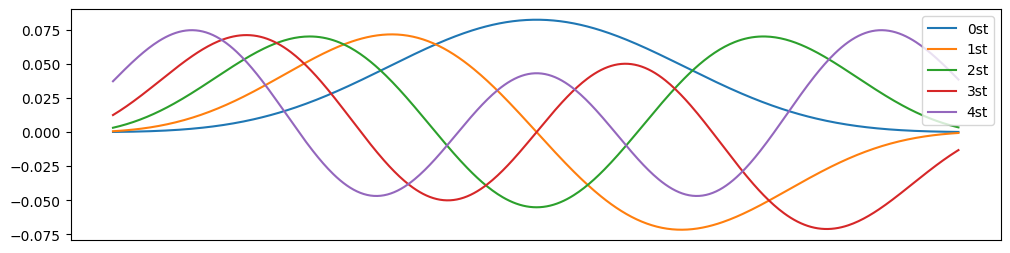

nw:3, N:500, W:3.0


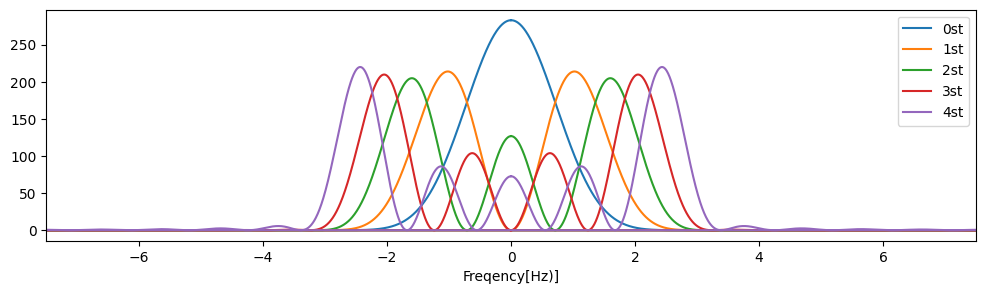

In [187]:
plt.figure(figsize=(12, 3))

for k_i in range(MTSpec.K):
    # k_i 番目のターパー
    plt.plot(MTSpec.k_DPSS[k_i, :], label=f'{k_i}st') 
    print(f"{k_i}th {MTSpec.eigenvalues[k_i]}")

plt.xticks([])
# plt.grid()
plt.legend(loc='upper right')
plt.show()


H_k = np.fft.fft(MTSpec.k_DPSS, n=MTSpec.nfft, axis=1)
H_k_PSD = np.abs(H_k)**2 
freqs = np.fft.fftfreq(MTSpec.nfft, d=1/MTSpec.fs) # 周波数軸を対応させる
print(f"nw:{MTSpec.NW}, N:{MTSpec.N}, W:{MTSpec.NW / MTSpec.N * MTSpec.fs}")

plt.figure(figsize=(12, 3))
for k_i in range(MTSpec.K):
    # k_i 番目のターパー
    plt.plot(freqs, H_k_PSD[k_i,:], label=f'{k_i}st') 
plt.xlim(-MTSpec.NW / MTSpec.N * MTSpec.fs *2.5, MTSpec.NW / MTSpec.N * MTSpec.fs*2.5)
plt.xlabel("Freqency[Hz)]")
# plt.grid()
plt.legend(loc='upper right')
plt.show()

## SSVEP 4Hz

['EEG', 'suppl_info']


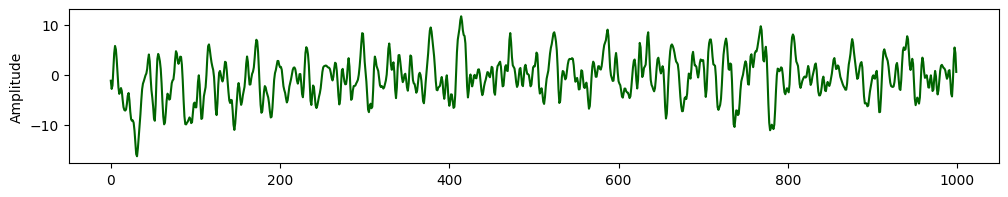

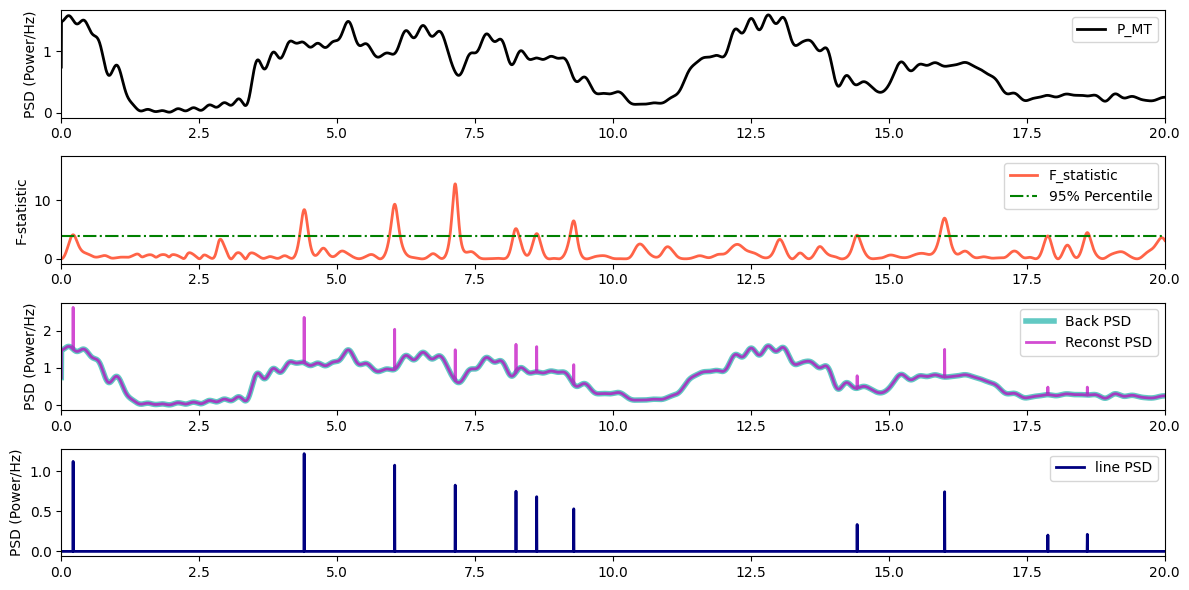

In [188]:
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat(
    '../../test_data/S16.mat',
    struct_as_record=False,
    squeeze_me=True
)

# (1,1) shape の struct: 例: data -> mat_struct
data_struct = mat_data["data"]  # これが mat_struct

# フィールド一覧を確認
print(data_struct._fieldnames)  # 例: ['EEG', 'suppl_info']

# フィールドへアクセス
EEG = getattr(data_struct, "EEG")         # data_struct.EEG と同等
info = getattr(data_struct, "suppl_info") # data_struct.suppl_info と同等

# Pz:48 O1 61
ssvep = EEG[48,:,0,1]
fs_vep = 256

# ハイパスフィルターの設定
cutoff = 0.2  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 20    # 阻止域最小減衰[dB]
ssvep = highpass(ssvep, fs_vep, cutoff, gpass, gstop)


cutoff = 60  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
ssvep = lowpass(ssvep, fs_vep, cutoff, gpass, gstop)


fig = plt.figure(1, figsize=(12,2))
ax = fig.add_subplot()
ax.plot(ssvep, color='darkgreen')
ax.set_ylabel("Amplitude")
plt.show()

MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(ssvep, fs_vep)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(4, 1, figsize=(12, 6))  # 3行1列のサブプロット

a = 0.95  # 透明度

# ---- 1つ目のプロット (PSD) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='P_MT', alpha=1, c='k', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,20)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()

# ---- 2つ目のプロット (F-statistic) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=2)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlim(0,20)
ax.legend()

# ---- 3つ目のプロット (Reconstructed PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='Back PSD', alpha=0.7, c='lightseagreen', lw=4)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.7, c='m', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,20)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- 4つ目のプロット (Reconstructed PSD) ----
ax = axes[3]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='navy', lw=2)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlim(0,20)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()